# Notebook to build training up from simplest case to real, eventually producing Figure S3 from Ujfalussy paper

In [1]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, poisson, norm

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *
from train_hLN import *
from init_hLN import *
from plot import *
from train_run import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams.update({'font.size': 18})

In [2]:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = [0]
# 2N
Jc_2n = [0, 1, 1]
# 3N
Jc_3n = [0, 1, 1, 2, 2, 3, 3]
# 4N
Jc_4n = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]

Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])

In [3]:
# Get some realistic inputs
X_tot = tf.convert_to_tensor(np.load('../Data/real_inputs.npy'), dtype=tf.float32)  # real inputs made earlier
X_e = X_tot[:629] # 629 excitatory inputs, in 13 ensembles
X_i = X_tot[629:] # 120 inhibitory inputs, also in 13 ensembles
# remember 1st inhibitory inputs is the somatic input - must always go to root subunit
inputs=X_tot

In [4]:
# now do multiple simulations for each case
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
hln_test = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accuracies, test_accuracies, trained_params_list, target_params_list = test_recovery(model=hln_test, inputs=inputs, num_sims=10)

100%|██████████| 4000/4000 [00:26<00:00, 148.65it/s]


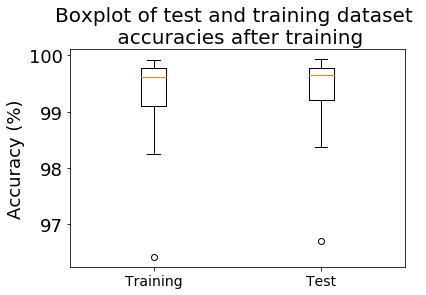

In [5]:
# box plot of recovered accuracies in hLN models
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.set_title('Boxplot of test and training dataset \n accuracies after training', fontsize=20)
ax.boxplot([train_accuracies, test_accuracies])
ax.set_xticklabels(['Training', 'Test'], fontsize=14)
ax.set_ylabel("Accuracy (%)")
# ax.set_ylim(100)
|
# plt.savefig("Figures/1l_accuracies_5attempts_10sims.png")
plt.show()

In [8]:
def plot_params_1l(trained_params, target_params, name="name", save=False):
    """create plots to compare trained parameters with target parameters for single subunit linear model.
    trained_params and target_params are lists of parameters for multiple recoveries returned by the test_recovery
    function."""

    trained_params, target_params = np.array(trained_params), np.array(target_params)

    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(15, 15)

    # extract the linear parameters we want for plotting
    trained_v0s, target_v0s = trained_params[:, 0], target_params[:, 0]
    trained_Wwes, target_Wwes = np.concatenate(trained_params[:, 2]), np.concatenate(target_params[:, 2])
    trained_logTaues, target_logTaues = np.concatenate(trained_params[:, 4]), np.concatenate(target_params[:, 4])
    trained_logDelays, target_logDelays = np.concatenate(trained_params[:, 7]), np.concatenate(target_params[:, 7]) 
    
    # convert log parameters to normal values
    trained_Taues, trained_Delays = np.exp(trained_logTaues), np.exp(trained_logDelays)
    target_Taues, target_Delays = np.exp(target_logTaues), np.exp(target_logDelays)
    
    # store all linear parameters in list
    lin_target_params = [target_v0s, target_Wwes, target_Taues, target_Delays]
    lin_trained_params = [trained_v0s, trained_Wwes, trained_Taues, trained_Delays]
    
    param_names = ["v0", "Wwe", "Taue", "Delay"]
    i=0
    for row in range(2):
        for col in range(2):
            # flatten input parameter arrays for plotting
            p_trained, p_target = lin_trained_params[i], lin_target_params[i]

            if len(p_trained) > 0:
                ax[row, col].scatter(p_target, p_trained)
                x = np.linspace(min(p_trained), max(p_trained), 100)
                ax[row, col].plot(x, x, color='red', label='Perfect recovery')
                ax[row, col].set_xlabel("Truth")
                ax[row, col].set_ylabel("Recovered")
                ax[row, col].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
                ax[row, col].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
                if len(p_trained) > 1:
                    var_explained = 1 - ((p_trained - p_target) ** 2).mean() / np.var(p_target)
                    ax[row, col].set_title(param_names[i] + f", ve = {100*var_explained:.2f}%")
                elif len(p_trained) == 1:
                    error = np.abs((p_trained[0] - p_target[0]) / p_target[0]) * 100
                    ax[row, col].set_title(param_names[i] + f", error ={error:.2f}%")
                ax[row, col].legend()

            i += 1

    if save:
        plt.savefig(name)

    plt.show()

    return

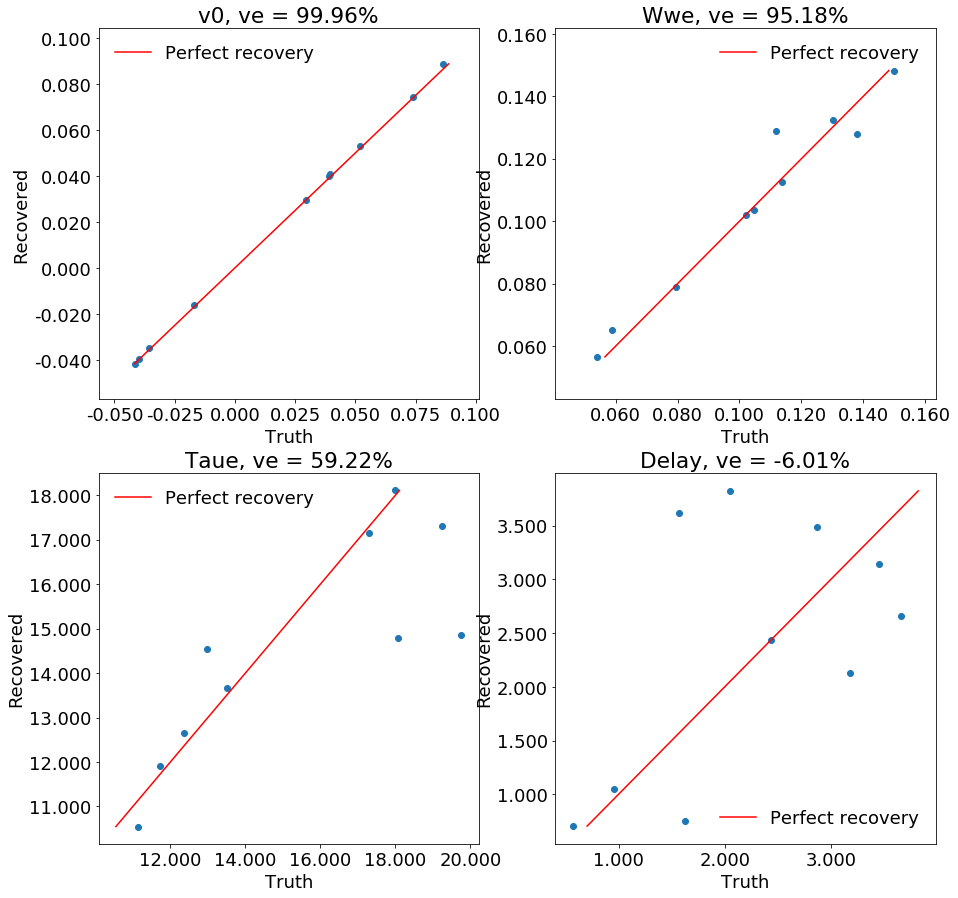

In [7]:
plot_params_1l(trained_params_list, target_params_list)

In [4]:
# test to see if 100% accuracy can be achieved with 
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
hln_1sim = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
# train_acc1, test_acc1, trained_params1, target_params1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=25, num_epochs=2000)

### Investigate how final training accuracy varies with num_attempts (number of different initial conditions training was started from) and num_epochs(number of training epochs) - we need the training loss to be 0


In [7]:
# investigate how final training accuracy varies with num_attempts (number of different initial conditions 
# training was started from) and num_epochs(number of training epochs)

# first set n_attempts = 1, change num_epochs
epochs = np.arange(100, 1100, 100)
train_accs = []
test_accs = []
for num_epochs in epochs:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=1, num_epochs=num_epochs, learning_rate=0.05)
    train_accs.append(train_acc[0].numpy())
    test_accs.append(test_acc[0].numpy())
    

100%|██████████| 1000/1000 [00:07<00:00, 141.76it/s]


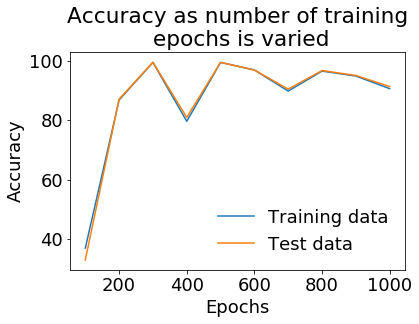

In [8]:
plt.plot(epochs, train_accs, label='Training data')
plt.plot(epochs, test_accs, label='Test data')
plt.legend()
plt.title("Accuracy as number of training\n epochs is varied")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [13]:
# now set num_epochs to minimum required for convergence (1000 seems sufficient from above cells), alter n_attempts
attempts = np.arange(1, 51, 10)
train_accs2 = []
test_accs2 = []
for n_attempts in attempts:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=n_attempts, num_epochs=200, learning_rate=0.05)
    train_accs2.append(train_acc[0].numpy())
    test_accs2.append(test_acc[0].numpy())

100%|██████████| 200/200 [00:01<00:00, 133.96it/s]


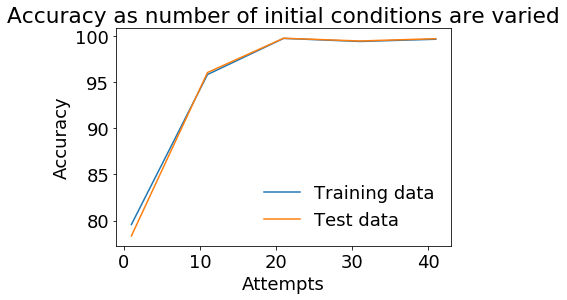

99.63339


In [15]:
plt.plot(attempts, train_accs2, label='Training data')
plt.plot(attempts, test_accs2, label='Test data')
plt.title("Accuracy as number of initial conditions are varied")
plt.xlabel("Attempts")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print(train_accs2[-1])

In [16]:
# seems to plateau after n_attempts=20 - try this level of attempts for different numbers of training epochs
epochs = np.arange(100, 1100, 100)
train_accs3 = []
test_accs3 = []
for num_epochs in epochs:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=num_epochs, learning_rate=0.05)
    train_accs3.append(train_acc[0].numpy())
    test_accs3.append(test_acc[0].numpy())
    

100%|██████████| 1000/1000 [00:07<00:00, 142.80it/s]


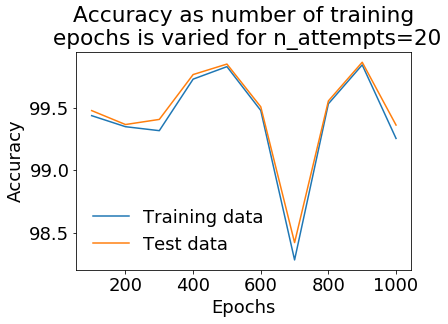

In [17]:
plt.plot(epochs, train_accs3, label='Training data')
plt.plot(epochs, test_accs3, label='Test data')
plt.legend()
plt.title("Accuracy as number of training\n epochs is varied for n_attempts=20")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

### Test theory 1: see if 100% training accuracy can be achieved with grad_subset function

In [11]:
# now do multiple simulations for each case
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
# hln_subset = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_subset, test_accs_subset, trained_params_list, target_params_list = test_recovery(model=hln_subset, inputs=inputs, num_sims=10, n_attempts=20, num_epochs=500, learning_rate=0.05)



100%|██████████| 500/500 [00:03<00:00, 158.77it/s]

100%|██████████| 500/500 [00:03<00:00, 161.58it/s]

100%|██████████| 500/500 [00:03<00:00, 151.40it/s]

100%|██████████| 500/500 [00:03<00:00, 144.56it/s]

100%|██████████| 500/500 [00:03<00:00, 152.51it/s]

100%|██████████| 500/500 [00:03<00:00, 164.45it/s]

100%|██████████| 500/500 [00:03<00:00, 160.45it/s]

100%|██████████| 500/500 [00:03<00:00, 161.37it/s]

100%|██████████| 500/500 [00:03<00:00, 156.56it/s]

 81%|████████  | 406/500 [00:02<00:00, 151.03it/s]


100%|██████████| 500/500 [00:03<00:00, 150.54it/s]

100%|██████████| 500/500 [00:03<00:00, 162.60it/s]

100%|██████████| 500/500 [00:03<00:00, 160.33it/s]

100%|██████████| 500/500 [00:03<00:00, 155.72it/s]

100%|██████████| 500/500 [00:03<00:00, 135.57it/s]

100%|██████████| 500/500 [00:03<00:00, 156.51it/s]

100%|██████████| 500/500 [00:02<00:00, 167.94it/s]

100%|██████████| 500/500 [00:02<00:00, 168.26it/s]

100%|██████████| 500/500 [00:03<00:00, 165.51it/s]

100%|██████████| 500/500 [00:03<00:00, 142.47it/s]

 61%|██████    | 304/500 [00:02<00:01, 148.61it/s]


100%|██████████| 500/500 [00:03<00:00, 149.33it/s]

100%|██████████| 500/500 [00:03<00:00, 164.88it/s]

100%|██████████| 500/500 [00:03<00:00, 165.42it/s]

100%|██████████| 500/500 [00:03<00:00, 165.69it/s]

100%|██████████| 500/500 [00:03<00:00, 153.90it/s]

100%|██████████| 500/500 [00:03<00:00, 160.86it/s]

100%|██████████| 500/500 [00:02<00:00, 167.26it/s]

100%|██████████| 500/500 [00:02<00:00, 169.54it/s]

100%|██████████| 500/500 [00:03<00:00, 164.18it/s]

100%|██████████| 500/500 [00:03<00:00, 164.75it/s]

 85%|████████▌ | 426/500 [00:02<00:00, 137.07it/s]


100%|██████████| 500/500 [00:03<00:00, 154.98it/s]

100%|██████████| 500/500 [00:03<00:00, 159.21it/s]

100%|██████████| 500/500 [00:03<00:00, 164.64it/s]

100%|██████████| 500/500 [00:03<00:00, 146.65it/s]

100%|██████████| 500/500 [00:03<00:00, 137.11it/s]

100%|██████████| 500/500 [00:03<00:00, 163.43it/s]

100%|██████████| 500/500 [00:03<00:00, 155.75it/s]

100%|██████████| 500/500 [00:03<00:00, 158.35it/s]

100%|██████████| 500/500 [00:03<00:00, 162.07it/s]

100%|██████████| 500/500 [00:03<00:00, 164.31it/s]

 79%|███████▊  | 393/500 [00:02<00:00, 165.40it/s]


100%|██████████| 500/500 [00:03<00:00, 165.38it/s]

100%|██████████| 500/500 [00:03<00:00, 148.23it/s]

100%|██████████| 500/500 [00:03<00:00, 162.93it/s]

100%|██████████| 500/500 [00:03<00:00, 156.13it/s]

100%|██████████| 500/500 [00:03<00:00, 156.17it/s]

100%|██████████| 500/500 [00:03<00:00, 158.45it/s]

100%|██████████| 500/500 [00:03<00:00, 147.63it/s]

100%|██████████| 500/500 [00:03<00:00, 162.76it/s]

100%|██████████| 500/500 [00:03<00:00, 160.70it/s]

100%|██████████| 500/500 [00:03<00:00, 154.89it/s]

 55%|█████▍    | 274/500 [00:01<00:01, 151.88it/s]


100%|██████████| 500/500 [00:03<00:00, 153.78it/s]

100%|██████████| 500/500 [00:03<00:00, 166.27it/s]

100%|██████████| 500/500 [00:03<00:00, 152.32it/s]

100%|██████████| 500/500 [00:03<00:00, 163.14it/s]

100%|██████████| 500/500 [00:03<00:00, 161.75it/s]

100%|██████████| 500/500 [00:03<00:00, 163.94it/s]

100%|██████████| 500/500 [00:03<00:00, 166.13it/s]

100%|██████████| 500/500 [00:03<00:00, 162.53it/s]

100%|██████████| 500/500 [00:03<00:00, 163.82it/s]

100%|██████████| 500/500 [00:03<00:00, 151.67it/s]

 60%|██████    | 301/500 [00:01<00:01, 156.36it/s]


100%|██████████| 500/500 [00:03<00:00, 150.85it/s]

100%|██████████| 500/500 [00:03<00:00, 153.25it/s]

100%|██████████| 500/500 [00:03<00:00, 161.30it/s]

100%|██████████| 500/500 [00:03<00:00, 161.46it/s]

100%|██████████| 500/500 [00:03<00:00, 155.73it/s]

100%|██████████| 500/500 [00:03<00:00, 156.48it/s]

100%|██████████| 500/500 [00:03<00:00, 160.26it/s]

100%|██████████| 500/500 [00:03<00:00, 161.24it/s]

100%|██████████| 500/500 [00:03<00:00, 155.89it/s]

100%|██████████| 500/500 [00:03<00:00, 155.01it/s]

 54%|█████▍    | 272/500 [00:01<00:01, 153.47it/s]


100%|██████████| 500/500 [00:03<00:00, 154.67it/s]

100%|██████████| 500/500 [00:03<00:00, 155.89it/s]

100%|██████████| 500/500 [00:03<00:00, 163.13it/s]

100%|██████████| 500/500 [00:03<00:00, 159.84it/s]

100%|██████████| 500/500 [00:03<00:00, 162.86it/s]

100%|██████████| 500/500 [00:03<00:00, 158.64it/s]

100%|██████████| 500/500 [00:03<00:00, 165.95it/s]

100%|██████████| 500/500 [00:03<00:00, 166.05it/s]

100%|██████████| 500/500 [00:03<00:00, 164.09it/s]

100%|██████████| 500/500 [00:03<00:00, 163.94it/s]

 66%|██████▌   | 330/500 [00:02<00:01, 162.17it/s]


100%|██████████| 500/500 [00:03<00:00, 160.89it/s]

100%|██████████| 500/500 [00:03<00:00, 166.22it/s]

100%|██████████| 500/500 [00:03<00:00, 164.89it/s]

100%|██████████| 500/500 [00:03<00:00, 163.97it/s]

100%|██████████| 500/500 [00:03<00:00, 162.74it/s]

100%|██████████| 500/500 [00:03<00:00, 162.48it/s]

100%|██████████| 500/500 [00:03<00:00, 165.54it/s]

100%|██████████| 500/500 [00:03<00:00, 164.58it/s]

100%|██████████| 500/500 [00:03<00:00, 165.94it/s]

100%|██████████| 500/500 [00:03<00:00, 163.43it/s]

 84%|████████▎ | 418/500 [00:02<00:00, 160.46it/s]


100%|██████████| 500/500 [00:03<00:00, 158.61it/s]

100%|██████████| 500/500 [00:03<00:00, 165.12it/s]

100%|██████████| 500/500 [00:03<00:00, 164.19it/s]

100%|██████████| 500/500 [00:03<00:00, 153.25it/s]

100%|██████████| 500/500 [00:03<00:00, 137.95it/s]

100%|██████████| 500/500 [00:03<00:00, 143.58it/s]

100%|██████████| 500/500 [00:03<00:00, 149.78it/s]

100%|██████████| 500/500 [00:03<00:00, 160.18it/s]

100%|██████████| 500/500 [00:03<00:00, 145.57it/s]

100%|██████████| 500/500 [00:03<00:00, 140.97it/s]

 30%|███       | 150/500 [00:01<00:02, 132.36it/s]


100%|██████████| 500/500 [00:03<00:00, 137.61it/s]

100%|██████████| 500/500 [00:02<00:00, 168.78it/s]

100%|██████████| 500/500 [00:02<00:00, 168.69it/s]

100%|██████████| 500/500 [00:03<00:00, 165.01it/s]

100%|██████████| 500/500 [00:03<00:00, 162.98it/s]

100%|██████████| 500/500 [00:03<00:00, 165.46it/s]

100%|██████████| 500/500 [00:02<00:00, 169.24it/s]

100%|██████████| 500/500 [00:03<00:00, 166.30it/s]

100%|██████████| 500/500 [00:02<00:00, 167.42it/s]

100%|██████████| 500/500 [00:03<00:00, 163.86it/s]

 54%|█████▍    | 271/500 [00:01<00:01, 164.75it/s]


100%|██████████| 500/500 [00:03<00:00, 164.90it/s]

100%|██████████| 500/500 [00:02<00:00, 168.55it/s]

100%|██████████| 500/500 [00:02<00:00, 169.19it/s]

100%|██████████| 500/500 [00:03<00:00, 166.21it/s]

100%|██████████| 500/500 [00:02<00:00, 167.58it/s]

100%|██████████| 500/500 [00:02<00:00, 167.09it/s]

100%|██████████| 500/500 [00:02<00:00, 168.83it/s]

100%|██████████| 500/500 [00:02<00:00, 169.90it/s]

100%|██████████| 500/500 [00:03<00:00, 166.04it/s]

100%|██████████| 500/500 [00:02<00:00, 167.38it/s]

 96%|█████████▌| 481/500 [00:02<00:00, 167.68it/s]


100%|██████████| 500/500 [00:02<00:00, 166.75it/s]

100%|██████████| 500/500 [00:02<00:00, 170.04it/s]

100%|██████████| 500/500 [00:02<00:00, 169.40it/s]

100%|██████████| 500/500 [00:02<00:00, 169.44it/s]

100%|██████████| 500/500 [00:03<00:00, 162.77it/s]

100%|██████████| 500/500 [00:03<00:00, 166.10it/s]

100%|██████████| 500/500 [00:02<00:00, 170.42it/s]

100%|██████████| 500/500 [00:03<00:00, 165.03it/s]

100%|██████████| 500/500 [00:02<00:00, 169.16it/s]

100%|██████████| 500/500 [00:03<00:00, 166.29it/s]

100%|██████████| 500/500 [00:03<00:00, 165.29it/s]

 31%|███       | 155/500 [00:00<00:02, 164.94it/s]


100%|██████████| 500/500 [00:02<00:00, 168.98it/s]

100%|██████████| 500/500 [00:02<00:00, 170.76it/s]

100%|██████████| 500/500 [00:03<00:00, 152.20it/s]

100%|██████████| 500/500 [00:03<00:00, 164.81it/s]

100%|██████████| 500/500 [00:03<00:00, 166.66it/s]

100%|██████████| 500/500 [00:03<00:00, 165.70it/s]

100%|██████████| 500/500 [00:02<00:00, 169.36it/s]

100%|██████████| 500/500 [00:02<00:00, 167.62it/s]

100%|██████████| 500/500 [00:02<00:00, 167.96it/s]

100%|██████████| 500/500 [00:02<00:00, 167.93it/s]

 68%|██████▊   | 340/500 [00:02<00:00, 163.88it/s]


100%|██████████| 500/500 [00:03<00:00, 165.99it/s]

100%|██████████| 500/500 [00:03<00:00, 157.87it/s]

100%|██████████| 500/500 [00:03<00:00, 161.71it/s]

100%|██████████| 500/500 [00:03<00:00, 156.85it/s]

100%|██████████| 500/500 [00:03<00:00, 149.68it/s]

100%|██████████| 500/500 [00:02<00:00, 176.73it/s]

100%|██████████| 500/500 [00:03<00:00, 136.76it/s]

100%|██████████| 500/500 [00:04<00:00, 110.78it/s]

100%|██████████| 500/500 [00:02<00:00, 170.44it/s]

100%|██████████| 500/500 [00:02<00:00, 175.10it/s]

 58%|█████▊    | 291/500 [00:01<00:01, 172.22it/s]


100%|██████████| 500/500 [00:02<00:00, 177.26it/s]

100%|██████████| 500/500 [00:02<00:00, 175.00it/s]

100%|██████████| 500/500 [00:02<00:00, 173.62it/s]

100%|██████████| 500/500 [00:03<00:00, 165.99it/s]

100%|██████████| 500/500 [00:02<00:00, 171.74it/s]

100%|██████████| 500/500 [00:02<00:00, 169.25it/s]

100%|██████████| 500/500 [00:02<00:00, 168.13it/s]

100%|██████████| 500/500 [00:03<00:00, 165.39it/s]

100%|██████████| 500/500 [00:03<00:00, 164.15it/s]

100%|██████████| 500/500 [00:03<00:00, 154.00it/s]

100%|██████████| 500/500 [00:02<00:00, 176.55it/s]

 21%|██        | 103/500 [00:00<00:02, 165.28it/s]


100%|██████████| 500/500 [00:02<00:00, 173.74it/s]

100%|██████████| 500/500 [00:02<00:00, 168.92it/s]

100%|██████████| 500/500 [00:03<00:00, 161.61it/s]

100%|██████████| 500/500 [00:03<00:00, 165.63it/s]

100%|██████████| 500/500 [00:03<00:00, 160.12it/s]

100%|██████████| 500/500 [00:03<00:00, 154.24it/s]

100%|██████████| 500/500 [00:02<00:00, 175.52it/s]

100%|██████████| 500/500 [00:02<00:00, 172.59it/s]

100%|██████████| 500/500 [00:02<00:00, 171.36it/s]

100%|██████████| 500/500 [00:02<00:00, 173.43it/s]

 89%|████████▉ | 445/500 [00:02<00:00, 182.34it/s]


100%|██████████| 500/500 [00:02<00:00, 179.41it/s]

100%|██████████| 500/500 [00:02<00:00, 178.11it/s]

100%|██████████| 500/500 [00:02<00:00, 173.21it/s]

100%|██████████| 500/500 [00:02<00:00, 180.26it/s]

100%|██████████| 500/500 [00:02<00:00, 178.77it/s]

100%|██████████| 500/500 [00:02<00:00, 176.29it/s]

100%|██████████| 500/500 [00:02<00:00, 180.80it/s]

100%|██████████| 500/500 [00:02<00:00, 176.65it/s]

100%|██████████| 500/500 [00:03<00:00, 160.12it/s]

100%|██████████| 500/500 [00:02<00:00, 169.39it/s]

100%|██████████| 500/500 [00:03<00:00, 165.34it/s]

 78%|███████▊  | 392/500 [00:02<00:00, 166.13it/s]


100%|██████████| 500/500 [00:02<00:00, 170.65it/s]

100%|██████████| 500/500 [00:02<00:00, 166.73it/s]

100%|██████████| 500/500 [00:03<00:00, 160.12it/s]

100%|██████████| 500/500 [00:03<00:00, 144.90it/s]

100%|██████████| 500/500 [00:03<00:00, 125.59it/s]

100%|██████████| 500/500 [00:03<00:00, 136.41it/s]

100%|██████████| 500/500 [00:03<00:00, 148.54it/s]

100%|██████████| 500/500 [00:03<00:00, 147.40it/s]

100%|██████████| 500/500 [00:03<00:00, 146.22it/s]

100%|██████████| 500/500 [00:03<00:00, 155.21it/s]

 29%|██▊       | 143/500 [00:00<00:02, 175.06it/s]


100%|██████████| 500/500 [00:02<00:00, 175.39it/s]

100%|██████████| 500/500 [00:02<00:00, 176.29it/s]

100%|██████████| 500/500 [00:02<00:00, 178.15it/s]

100%|██████████| 500/500 [00:02<00:00, 180.33it/s]

100%|██████████| 500/500 [00:02<00:00, 179.29it/s]

100%|██████████| 500/500 [00:02<00:00, 180.11it/s]

100%|██████████| 500/500 [00:02<00:00, 179.47it/s]

100%|██████████| 500/500 [00:02<00:00, 180.73it/s]


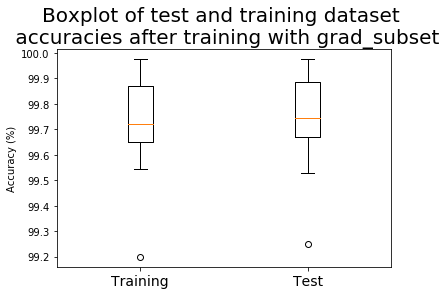

In [12]:
# matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.set_title('Boxplot of test and training dataset \n accuracies after training with grad_subset', fontsize=20)
ax.boxplot([train_accs_subset, test_accs_subset])
ax.set_xticklabels(['Training', 'Test'], fontsize=14)
ax.set_ylabel("Accuracy (%)")
# ax.set_ylim(100)
# plt.savefig("Figures/1l_accuracies_5attempts_10sims.png")
plt.show()

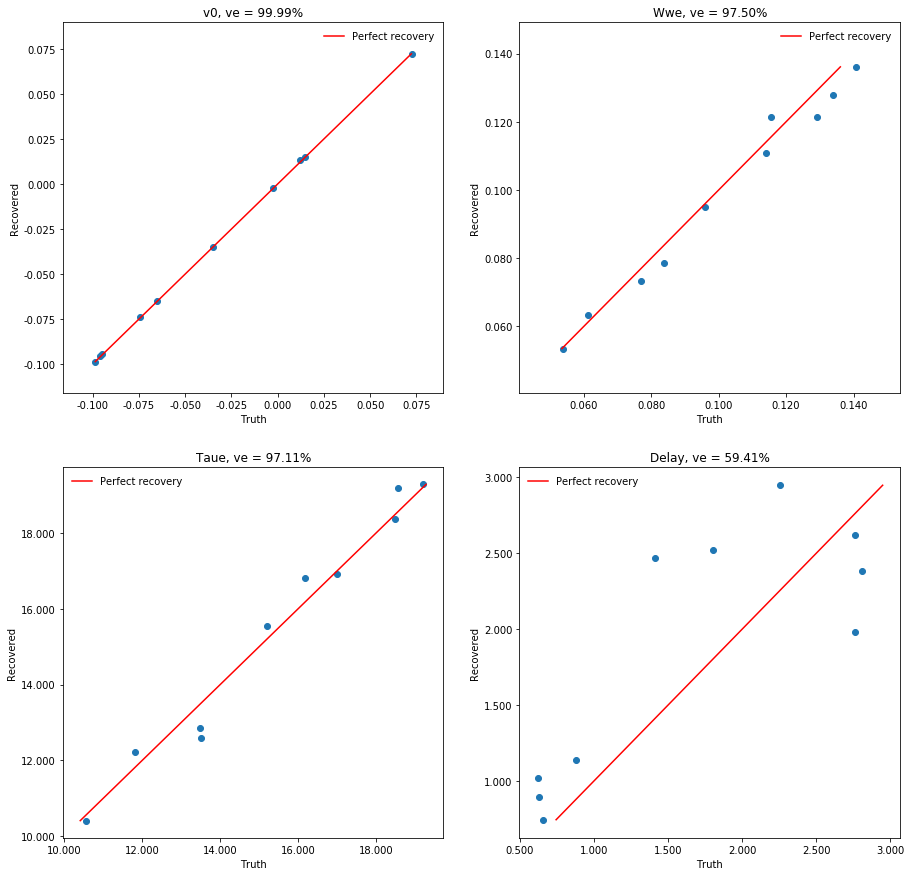

In [16]:
plot_params_1l(trained_params_list, target_params_list)

#### Just train single sim for very long time to see if accuracy will converge to 100 - it doesn't 

In [17]:
# now do multiple simulations for each case
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
# hln_subset = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_normal, test_accs_normal, trained_ps_normal, target_ps_normal = test_recovery(model=hln_subset, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=5000, learning_rate=0.05)



 98%|█████████▊| 4913/5000 [00:30<00:00, 160.17it/s]


100%|██████████| 5000/5000 [00:31<00:00, 161.10it/s]

 96%|█████████▋| 4824/5000 [00:29<00:01, 160.89it/s]


100%|██████████| 5000/5000 [00:31<00:00, 161.13it/s]

 95%|█████████▌| 4750/5000 [00:29<00:01, 161.70it/s]


100%|██████████| 5000/5000 [00:30<00:00, 161.63it/s]

 92%|█████████▏| 4592/5000 [00:29<00:02, 154.57it/s]


100%|██████████| 5000/5000 [00:31<00:00, 157.40it/s]

 88%|████████▊ | 4392/5000 [00:28<00:03, 156.37it/s]


100%|██████████| 5000/5000 [00:31<00:00, 156.62it/s]

 80%|████████  | 4004/5000 [00:27<00:06, 153.41it/s]


100%|██████████| 5000/5000 [00:33<00:00, 149.81it/s]

 77%|███████▋  | 3826/5000 [00:24<00:07, 150.42it/s]


100%|██████████| 5000/5000 [00:31<00:00, 157.93it/s]

 74%|███████▎  | 3677/5000 [00:23<00:08, 156.88it/s]


100%|██████████| 5000/5000 [00:31<00:00, 158.95it/s]

 70%|███████   | 3510/5000 [00:22<00:09, 153.47it/s]


100%|██████████| 5000/5000 [00:31<00:00, 156.51it/s]

 67%|██████▋   | 3349/5000 [00:21<00:10, 157.79it/s]


100%|██████████| 5000/5000 [00:31<00:00, 156.46it/s]

 64%|██████▍   | 3197/5000 [00:20<00:10, 175.79it/s]


100%|██████████| 5000/5000 [00:30<00:00, 162.93it/s]

 65%|██████▌   | 3253/5000 [00:20<00:13, 125.75it/s]


100%|██████████| 5000/5000 [00:33<00:00, 148.80it/s]

 54%|█████▍    | 2720/5000 [00:18<00:13, 174.16it/s]


100%|██████████| 5000/5000 [00:31<00:00, 159.98it/s]

 61%|██████    | 3060/5000 [00:17<00:10, 176.51it/s]


100%|██████████| 5000/5000 [00:28<00:00, 175.34it/s]

 70%|██████▉   | 3480/5000 [00:19<00:08, 183.76it/s]


100%|██████████| 5000/5000 [00:27<00:00, 180.02it/s]

 79%|███████▉  | 3964/5000 [00:22<00:05, 180.60it/s]


100%|██████████| 5000/5000 [00:29<00:00, 170.27it/s]

 77%|███████▋  | 3834/5000 [00:23<00:07, 164.10it/s]


100%|██████████| 5000/5000 [00:30<00:00, 161.74it/s]

 77%|███████▋  | 3836/5000 [00:23<00:07, 162.03it/s]


100%|██████████| 5000/5000 [00:30<00:00, 164.74it/s]

 75%|███████▌  | 3767/5000 [00:23<00:07, 163.55it/s]


100%|██████████| 5000/5000 [00:30<00:00, 161.67it/s]

 76%|███████▋  | 3819/5000 [00:23<00:07, 161.70it/s]


100%|██████████| 5000/5000 [00:30<00:00, 166.49it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.992386>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.993225>]


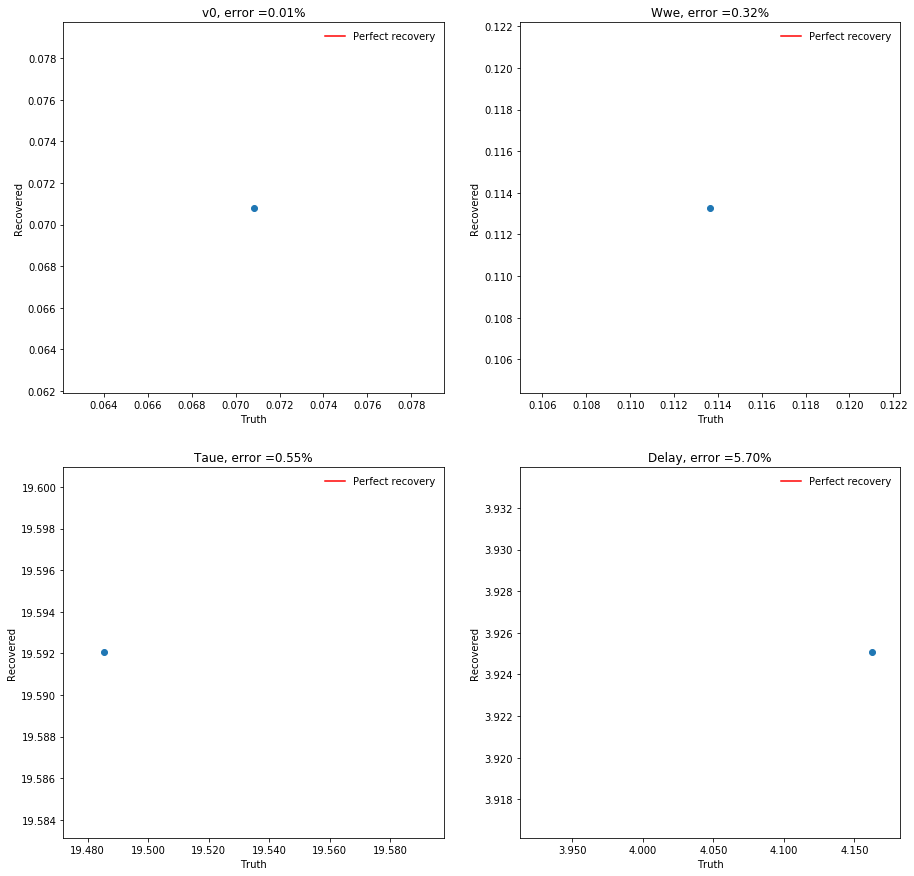

In [21]:
print(train_accs_normal, test_accs_normal)
plot_params_1l(trained_ps_normal, target_ps_normal)

In [24]:
# now do multiple simulations for each case
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
# hln_subset = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_normal, test_accs_normal, trained_ps_normal, target_ps_normal = test_recovery(model=hln_subset, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=20000, learning_rate=0.05)


 24%|██▍       | 4758/20000 [00:30<01:34, 160.76it/s]


 48%|████▊     | 9581/20000 [00:59<01:04, 161.03it/s]


 72%|███████▏  | 14324/20000 [01:29<00:35, 160.91it/s]


 95%|█████████▌| 19086/20000 [01:58<00:05, 158.32it/s]


100%|██████████| 20000/20000 [02:04<00:00, 160.58it/s]

 20%|█▉        | 3937/20000 [00:24<01:39, 162.16it/s]


 44%|████▍     | 8760/20000 [00:54<01:11, 157.82it/s]


 68%|██████▊   | 13574/20000 [01:23<00:40, 159.73it/s]


 92%|█████████▏| 18380/20000 [01:53<00:10, 159.83it/s]


100%|██████████| 20000/20000 [02:03<00:00, 162.34it/s]

 16%|█▌        | 3234/20000 [00:19<01:42, 163.19it/s]


 40%|████      | 8069/20000 [00:49<01:39, 119.73it/s]


 65%|██████▍   | 12921/20000 [01:19<00:43, 164.23it/s]


 89%|████████▊ | 17721/20000 [01:48<00:13, 164.28it/s]


100%|██████████| 20000/20000 [02:02<00:00, 163.05it/s]

 13%|█▎        | 2565/20000 [00:15<01:46, 163.46it/s]


 37%|███▋      | 7428/20000 [00:45<01:19, 158.89it/s]


 61%|██████▏   | 12277/20000 [01:15<00:47, 162.49it/s]


 85%|████████▌ | 17098/20000 [01:44<00:18, 160.03it/s]


100%|██████████| 20000/20000 [02:02<00:00, 163.63it/s]

 10%|▉         | 1962/20000 [00:11<01:50, 162.95it/s]


 34%|███▍      | 6835/20000 [00:41<01:22, 160.22it/s]


 58%|█████▊    | 11693/20000 [01:11<00:50, 165.00it/s]


 82%|████████▏ | 16498/20000 [01:40<00:22, 157.75it/s]


100%|██████████| 20000/20000 [02:02<00:00, 163.55it/s]

  7%|▋         | 1320/20000 [00:08<01:52, 165.46it/s]


 31%|███       | 6187/20000 [00:37<01:26, 160.59it/s]


 55%|█████▌    | 11038/20000 [01:07<00:54, 164.12it/s]


 79%|███████▉  | 15794/20000 [01:37<00:26, 156.33it/s]


100%|██████████| 20000/20000 [02:02<00:00, 162.96it/s]

  3%|▎         | 621/20000 [00:03<02:00, 160.70it/s]


 27%|██▋       | 5495/20000 [00:33<01:36, 150.12it/s]


 52%|█████▏    | 10357/20000 [01:03<01:00, 159.04it/s]


 76%|███████▌  | 15142/20000 [01:33<00:30, 161.02it/s]


100%|█████████▉| 19933/20000 [02:02<00:00, 160.84it/s]


100%|██████████| 20000/20000 [02:03<00:00, 162.22it/s]

 24%|██▍       | 4779/20000 [00:29<01:36, 157.50it/s]


 48%|████▊     | 9623/20000 [00:59<01:05, 157.40it/s]


 72%|███████▏  | 14444/20000 [01:28<00:35, 155.28it/s]


 96%|█████████▌| 19217/20000 [01:58<00:04, 159.67it/s]


100%|██████████| 20000/20000 [02:03<00:00, 162.31it/s]

 20%|██        | 4036/20000 [00:25<01:39, 159.99it/s]


 44%|████▍     | 8888/20000 [00:54<01:10, 157.86it/s]


 68%|██████▊   | 13689/20000 [01:24<00:40, 156.00it/s]


 92%|█████████▏| 18480/20000 [01:54<00:09, 155.12it/s]


100%|██████████| 20000/20000 [02:03<00:00, 162.11it/s]

 17%|█▋        | 3318/20000 [00:20<01:43, 160.57it/s]


 41%|████      | 8179/20000 [00:50<01:16, 153.88it/s]


 65%|██████▌   | 13011/20000 [01:20<00:44, 158.22it/s]


 90%|█████████ | 18008/20000 [01:49<00:10, 182.05it/s]


100%|██████████| 20000/20000 [02:01<00:00, 165.19it/s]

 17%|█▋        | 3334/20000 [00:18<01:32, 179.47it/s]


 43%|████▎     | 8647/20000 [00:48<01:02, 182.30it/s]


 70%|██████▉   | 13921/20000 [01:17<00:33, 181.80it/s]


 96%|█████████▌| 19183/20000 [01:47<00:04, 180.65it/s]


100%|██████████| 20000/20000 [01:51<00:00, 179.22it/s]

 23%|██▎       | 4547/20000 [00:25<01:27, 176.23it/s]


 49%|████▉     | 9891/20000 [00:55<00:56, 179.91it/s]


 76%|███████▌  | 15161/20000 [01:24<00:27, 177.45it/s]


100%|██████████| 20000/20000 [01:51<00:00, 179.32it/s]

  2%|▏         | 414/20000 [00:02<01:49, 179.32it/s]


 29%|██▊       | 5732/20000 [00:32<01:20, 178.22it/s]


 55%|█████▍    | 10997/20000 [01:01<00:50, 177.73it/s]


 81%|████████  | 16245/20000 [01:30<00:20, 180.89it/s]


100%|██████████| 20000/20000 [01:51<00:00, 178.70it/s]

  8%|▊         | 1549/20000 [00:08<01:43, 178.84it/s]


 34%|███▍      | 6887/20000 [00:38<01:12, 180.62it/s]


 61%|██████    | 12161/20000 [01:07<00:43, 180.64it/s]


 87%|████████▋ | 17422/20000 [01:37<00:14, 176.36it/s]


100%|██████████| 20000/20000 [01:51<00:00, 179.06it/s]

 14%|█▎        | 2710/20000 [00:15<01:36, 179.33it/s]


 40%|████      | 8019/20000 [00:44<01:07, 177.42it/s]


 67%|██████▋   | 13322/20000 [01:14<00:37, 180.44it/s]


 93%|█████████▎| 18573/20000 [01:43<00:07, 183.38it/s]


100%|██████████| 20000/20000 [01:51<00:00, 179.18it/s]

 19%|█▉        | 3859/20000 [00:21<01:29, 179.69it/s]


 46%|████▌     | 9163/20000 [00:51<00:59, 182.78it/s]


 72%|███████▏  | 14428/20000 [01:20<00:31, 176.67it/s]


 98%|█████████▊| 19679/20000 [01:50<00:01, 178.63it/s]


100%|██████████| 20000/20000 [01:51<00:00, 178.62it/s]

 25%|██▌       | 5029/20000 [00:27<01:22, 180.86it/s]


 52%|█████▏    | 10350/20000 [00:57<00:56, 171.46it/s]


 78%|███████▊  | 15582/20000 [01:27<00:25, 175.11it/s]


100%|██████████| 20000/20000 [01:51<00:00, 178.98it/s]

  4%|▍         | 858/20000 [00:04<01:46, 178.97it/s]


 31%|███       | 6195/20000 [00:34<01:16, 179.74it/s]


 58%|█████▊    | 11508/20000 [01:04<00:47, 178.22it/s]


 84%|████████▎ | 16740/20000 [01:33<00:18, 177.95it/s]


100%|██████████| 20000/20000 [01:51<00:00, 178.90it/s]

 10%|█         | 2039/20000 [00:11<01:40, 178.33it/s]


 37%|███▋      | 7389/20000 [00:41<01:10, 180.09it/s]


 63%|██████▎   | 12690/20000 [01:10<00:40, 180.29it/s]


 90%|████████▉ | 17939/20000 [01:40<00:11, 177.79it/s]


100%|██████████| 20000/20000 [01:51<00:00, 179.25it/s]

 16%|█▋        | 3274/20000 [00:18<01:33, 179.39it/s]


 43%|████▎     | 8625/20000 [00:48<01:03, 178.17it/s]


 69%|██████▉   | 13873/20000 [01:17<00:33, 181.07it/s]


 96%|█████████▌| 19118/20000 [01:46<00:05, 175.45it/s]


100%|██████████| 20000/20000 [01:51<00:00, 178.96it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.90364>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.910736>]


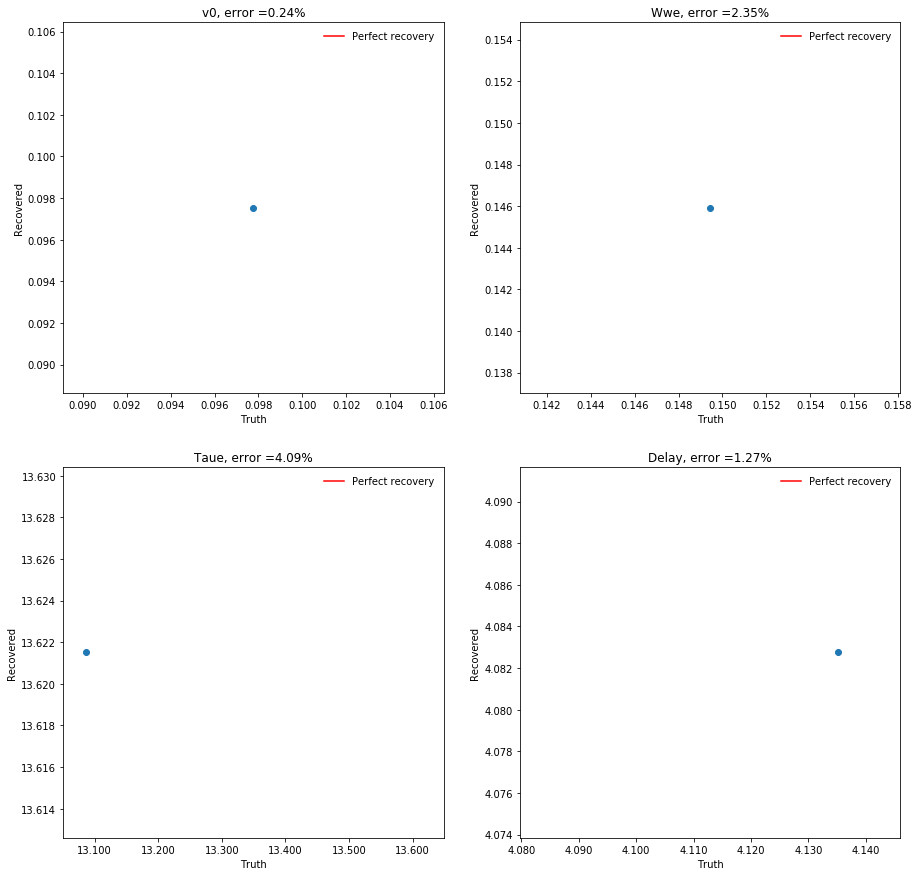

In [25]:
print(train_accs_normal, test_accs_normal)
plot_params_1l(trained_ps_normal, target_ps_normal)

### If grad_subset procedure doesn't get accuracy to 100%, try with a decaying learning rate

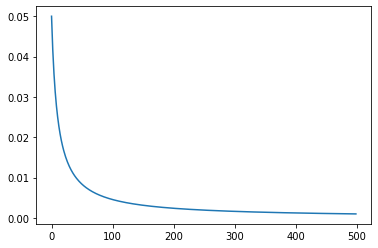

0.0009823182711198428

In [80]:
initial_rate=0.05
decay=0.1
lrates=[]
n_its = 500
iterations = np.arange(0, n_its, 1)
l_rates = initial_rate * (1/(1+decay*iterations))
plt.plot(iterations, l_rates)
plt.show()
l_rates[-1]

In [66]:
def train_sgd_decay(model, num_epochs, initial_rate, inputs, target, decay):
    """perform gradient descent training on a given hLN model for a specified number of epochs, while recording
    loss and accuracy information. Adjusted to perform SGD to prevent overfitting."""
    # create decaying learning rates
    iterations = np.arange(0, num_epochs, 1)
    l_rates = initial_rate  * (1/(1+decay*iterations))
    
    loss_values = []
    accuracies = []
    n_points = 1000
    n_train = int(len(target.numpy()))
    for epoch in tqdm(range(num_epochs)):
        t_start = int(np.random.uniform(0, n_train - n_points))
        loss_value, grads = grad_subset(model=model, inputs=inputs[:, t_start: t_start + n_points],
                                        targets=target[t_start:t_start + n_points])
        accuracy = 100 * (1 - (loss_value/np.var(target[t_start:t_start + n_points])))
        loss_values.append(loss_value.numpy())
        accuracies.append(max(accuracy.numpy(), 0))
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=l_rates[epoch])
        optimizer.apply_gradients(zip(grads, model.trainable_params))

    return loss_values, accuracies

In [35]:
# split input data into training and test sets, 80/20 initially
split = 0.8
L = inputs.shape[1]
n_train = int(L * split)
train_inputs = inputs[:, :n_train]
test_inputs = inputs[:, n_train:]

In [43]:
# now create simple hln model and train with decaying sgd
# hln_decay = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
hln_decay.randomise_parameters
decay_target = hln_decay(train_inputs)
decay_test_target = hln_decay(test_inputs)

In [74]:
hln_decay.randomise_parameters()
decay_losses, decay_accs = train_sgd_decay(hln_decay, num_epochs=500, initial_rate=0.05, inputs=train_inputs, target=decay_target, decay=0.1)


100%|██████████| 500/500 [00:16<00:00, 29.41it/s]


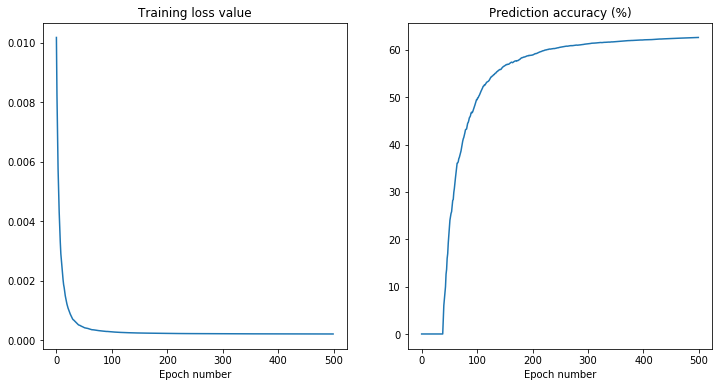

Final training loss: 2.01E-04, Final training accuracy:62.62%
Test loss: 2.40E-04, Test accuracy:63.15%


In [75]:
plot_loss_acc(hln_decay, decay_losses, decay_accs, inputs=test_inputs, target=decay_test_target)

## We need to work out why 100% recovery isn't possible - start from known target parameters and peturb slightly, when does 100% become impossible

### First change v0 only - based on previous recovery hope for 100% from here

In [6]:
# now do multiple simulations for each case
hln_v0 = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_v0, test_accs_v0, trained_plist_v0, target_plist_v0 = test_recovery(model=hln_v0, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=500, learning_rate=0.05)


100%|██████████| 500/500 [00:03<00:00, 163.56it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.99955>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.99956>]


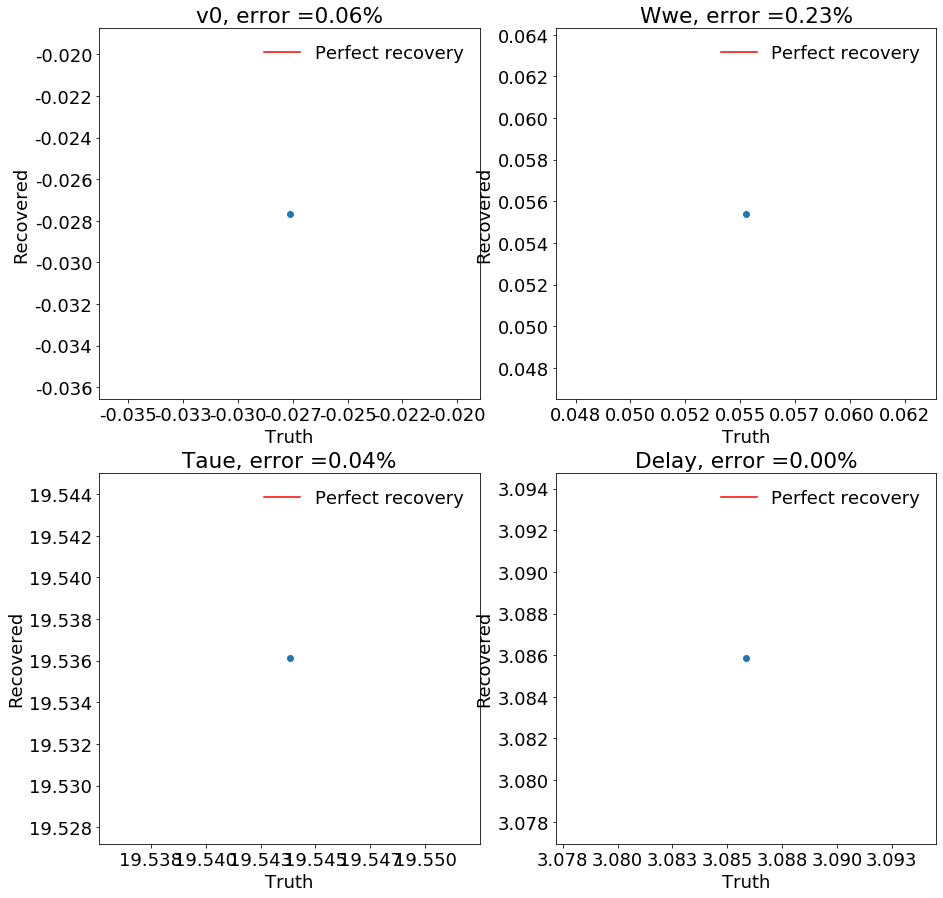

In [7]:
print(train_accs_v0, test_accs_v0)
plot_params_1l(trained_plist_v0, target_plist_v0)

In [4]:
# now do multiple simulations for each case
hln_Wwe = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_Wwe, test_accs_Wwe, trained_plist_Wwe, target_plist_Wwe = test_recovery(model=hln_Wwe, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=500, learning_rate=0.05)


100%|██████████| 500/500 [00:03<00:00, 162.06it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.68536>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.70377>]


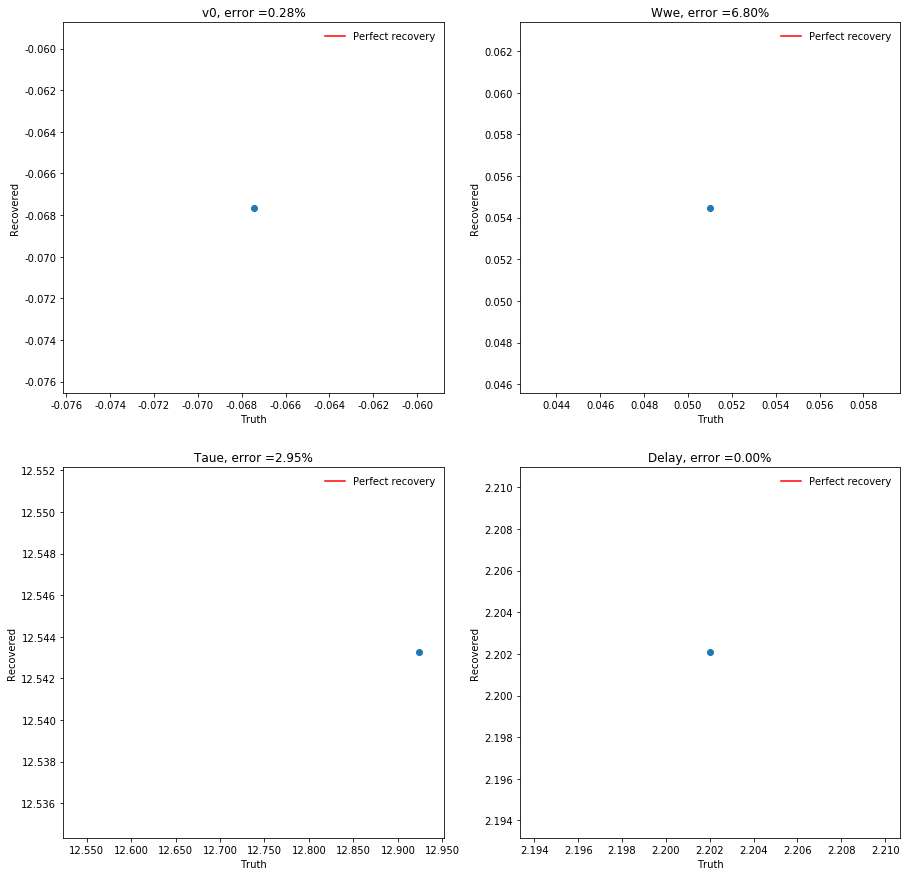

In [5]:
print(train_accs_Wwe, test_accs_Wwe)
plot_params_1l(trained_plist_Wwe, target_plist_Wwe)

In [4]:
# now do multiple simulations for each case
hln_Taue = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_Taue, test_accs_Taue, trained_plist_Taue, target_plist_Taue = test_recovery(model=hln_Taue, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=500, learning_rate=0.05)


100%|██████████| 500/500 [00:03<00:00, 165.27it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.99682>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.99678>]


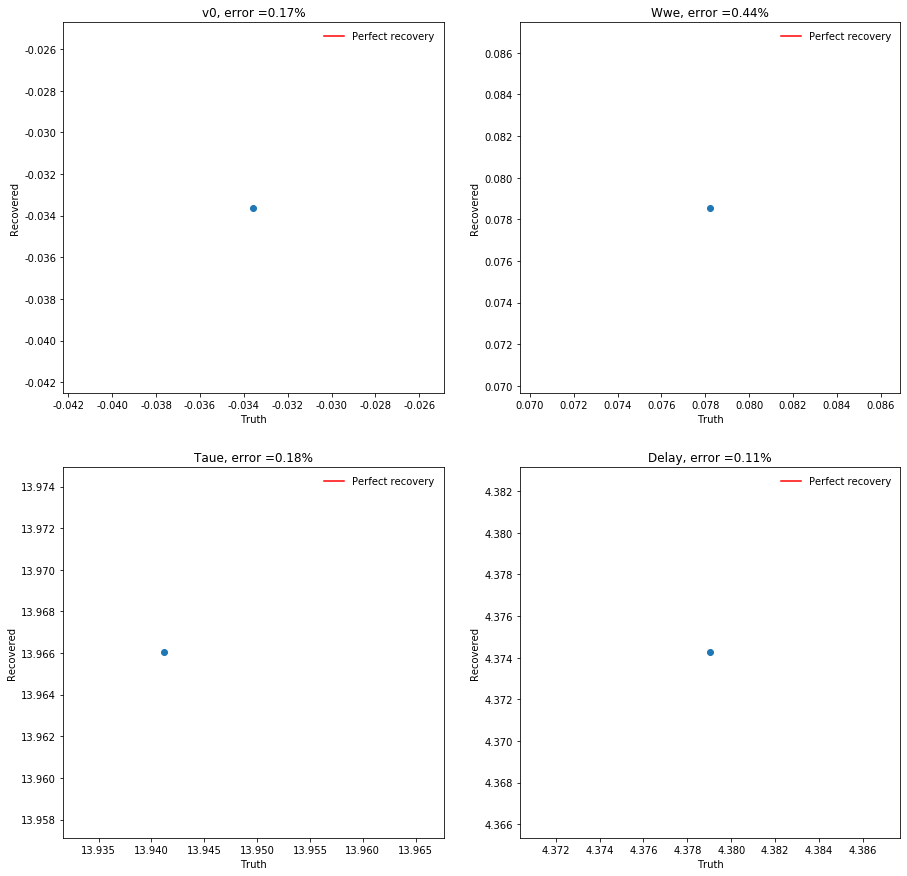

In [5]:
print(train_accs_Taue, test_accs_Taue)
plot_params_1l(trained_plist_Taue, target_plist_Taue)

In [8]:
# now do multiple simulations for each case
# hln_Delay = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_Delay, test_accs_Delay, trained_plist_Delay, target_plist_Delay = test_recovery(model=hln_Delay, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=1000, learning_rate=0.05)


100%|██████████| 1000/1000 [00:05<00:00, 169.83it/s]


[<tf.Tensor: shape=(), dtype=float32, numpy=99.999115>] [<tf.Tensor: shape=(), dtype=float32, numpy=99.99922>]


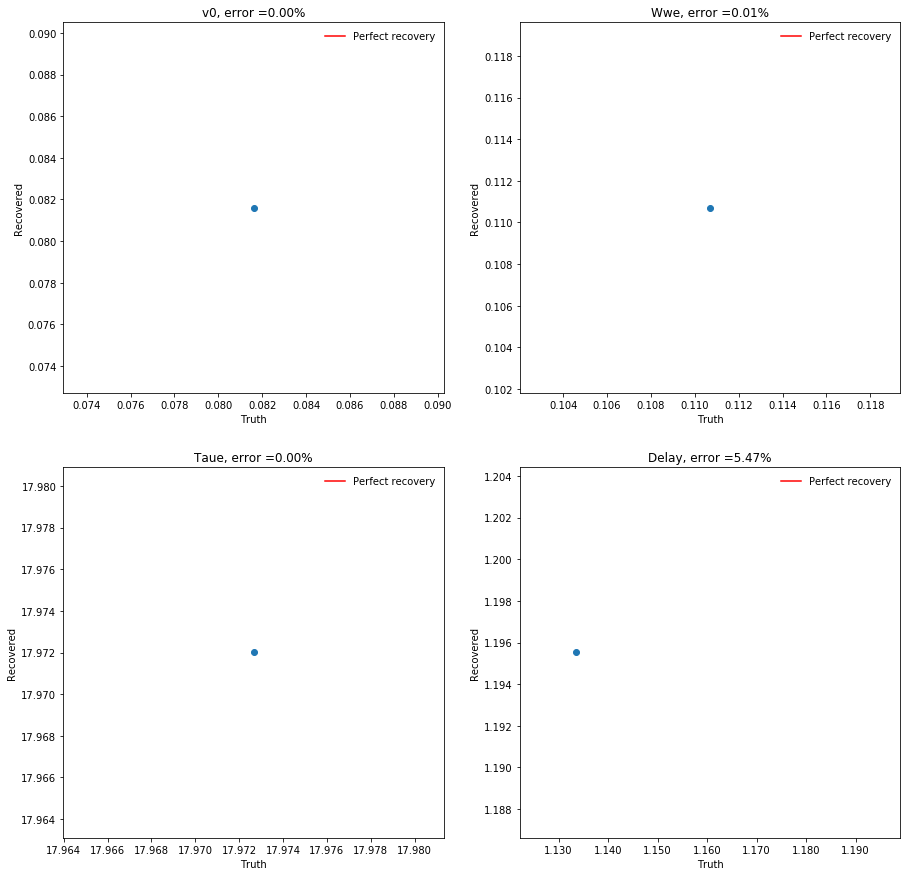

In [9]:
print(train_accs_Delay, test_accs_Delay)
plot_params_1l(trained_plist_Delay, target_plist_Delay)

### Even when changing just 1 parameter, 100% not achievable. Is data level a problem? - investigate by training on small sets of data

100%|██████████| 1000/1000 [00:04<00:00, 222.36it/s]


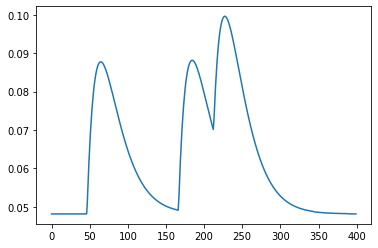

In [23]:
short_inputs = inputs[:, 600:1000]
target=hln_small(short_inputs)
plt.plot(target.numpy())


# hln_small = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_small, test_accs_small, trained_plist_small, target_plist_small = test_recovery(model=hln_small, inputs=short_inputs, num_sims=1, n_attempts=10, num_epochs=1000, learning_rate=0.1)




In [24]:
print(train_accs_small, test_accs_small)

[<tf.Tensor: shape=(), dtype=float32, numpy=99.595184>] [<tf.Tensor: shape=(), dtype=float32, numpy=-388.52576>]


### Still not quite 100%: we need to break it down even further. Carefully manufacture inputs instead of using realistic ones, then build up

In [52]:
# start with simple impulse:
delta = np.zeros(shape=(1,100))
delta[0,0]=1
delta=tf.convert_to_tensor(delta, dtype=tf.float32)



# hln_imp = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accs_imp, test_accs_imp, trained_plist_imp, target_plist_imp = test_recovery(model=hln_imp, inputs=delta, num_sims=5, n_attempts=10, num_epochs=20000, learning_rate=0.5)




100%|██████████| 20000/20000 [01:16<00:00, 262.35it/s]


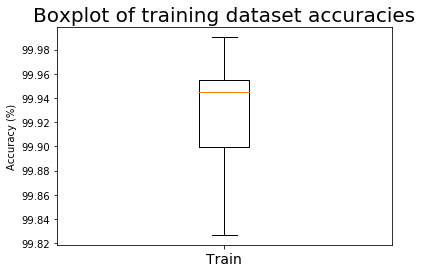

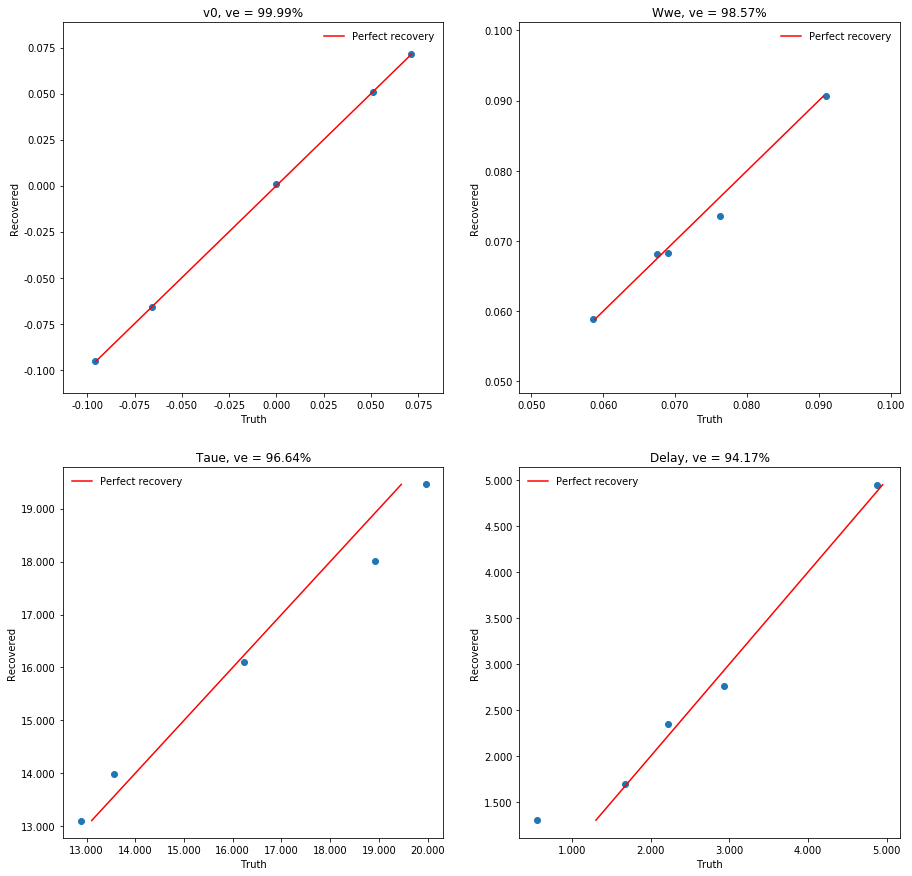

In [53]:
# box plot of recovered accuracies in hLN models
# matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.set_title('Boxplot of training dataset accuracies', fontsize=20)
ax.boxplot([train_accs_imp])
ax.set_xticklabels(['Train'], fontsize=14)
ax.set_ylabel("Accuracy (%)")
# ax.set_ylim(100)

plt.show()
plot_params_1l(trained_plist_imp, target_plist_imp)

In [49]:
hln_imp.randomise_parameters()
impulse_target = hln_imp(delta)
hln_imp.randomise_parameters()
# define optimizer
optimizer_1l = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.5)
# train model with SGD
# loss_values, accuracies = train_sgd(model=model, num_epochs=num_epochs, optimizer=optimizer_1l,
#                                     inputs=train_inputs, target=train_target)

# # train without SGD on a whole dataset
loss_values, accuracies = train(model=hln_imp, num_epochs=10000, optimizer=optimizer_1l,
                                    inputs=delta, target=impulse_target)

100%|██████████| 10000/10000 [00:35<00:00, 279.22it/s]


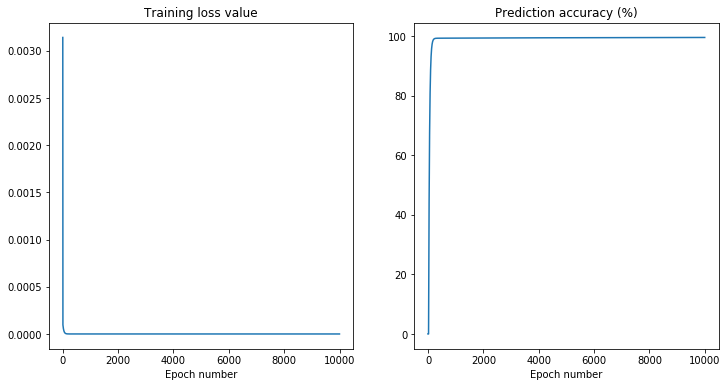

Final training loss: 2.46E-07, Final training accuracy:99.60%
Test loss: 2.46E-07, Test accuracy:99.60%


In [51]:
plot_loss_acc(model=hln_imp, loss_values=loss_values, 
              accuracies=accuracies, inputs=delta, target=impulse_target)

(100,)


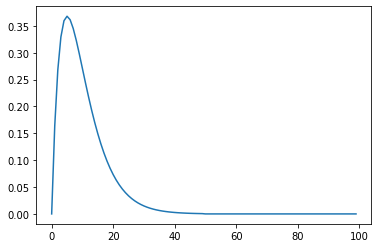

In [275]:
# define parameters
Wc = 0
Ww=1
Tau=5
delay=0
# conv = int_spikes(X=delta, dt=1, Wc=tf.constant(0, dtype=tf.int32), Ww=tf.constant(1, dtype=tf.float32), Tau=10, delay=0)
conv1 = alpha_filt(tau=Tau, spikes=delta, delay=delay, dt=1.)
conv2 = alpha_filt(tau=Tau, spikes=delta, delay=delay+1e-7, dt=1.)
print(conv1.shape)
plt.plot(conv1)

## Even with single impulse, 100% accuracy not achievable. Now rewrite sim_hLN_tf entirely, avoiding loops where possible, and try and train at each step of build to determine which component renders 100% accuracy unachievable

(10, 120)
(10, 40)
(1, 1, 120, 10)


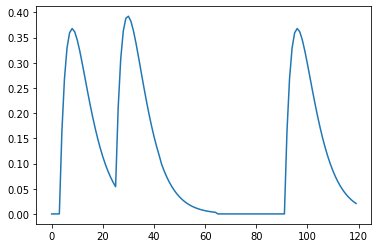

In [310]:
# test new convolution 
# create random binary inputs:
rand = np.random.binomial(1, 0.01, size=(10, 100))

filt_length=40

# add filt_length zeros to start of input, so we start convolving at the desired time
extended_input = np.hstack((np.zeros((10, int(filt_length/2))), rand))
print(extended_input.shape)

impulses = tf.reshape(extended_input.T, shape=[1, 1, 100+int(filt_length/2), 10])
impulses=tf.cast(impulses, tf.float32)

filt = np.tile(conv1[:filt_length][::-1], (10, 1))
print(filt.shape)
# plt.plot(filt[1])
filt = tf.reshape(filt.T, shape=[1, filt_length, 10, 1])
filt=tf.cast(filt, tf.float32)

# plt.plot(filt.numpy()[0,:,0,0].ravel())

# I = tf.reshape(I, [1,d,1,m])
# W = tf.reshape(W, [1,d,s,1])
stride=1
strides = [1,stride,1,1]
output = tf.nn.depthwise_conv2d(impulses, filt, strides, padding='SAME', data_format="NHWC", dilations=[1,1])
print(output.shape)
# output=tf.reshape(output, (10, 100))

# plt.plot(tf.reshape(output, [-1]).numpy())
# plt.show()
# plt.plot(tf.reshape(impulses, [-1]).numpy())
plt.plot(output[0,0,:,0].numpy().ravel())


(array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119]),)
(array([49, 84, 97]),)


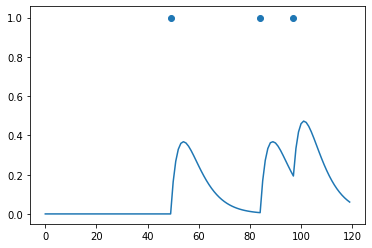

In [311]:
i=3
plt.plot(output[0,0,:,i].numpy().ravel())
plt.scatter(range(rand.shape[1]), np.where(rand[i], rand[i], np.nan))

print(np.nonzero(output[0,0,:,i].numpy().ravel()))
print(np.nonzero(rand[i]))

In [474]:
@tf.function
def sim_hLN_tf2(X, dt, Jc, Wce, Wci, params, sig_on):
    """new function to simulate subthreshold response of an hLN model. Should be simpler than old version (i.e. less
    for loops) and hopefully help achieve 100% accuracy on training data. Note Jw, Tau and Delay are defined by their
    logs to ensure positivity.
    
    X: N x T binarry input matrix of presynaptic spikes; N: # of inputs; T: # of timesteps
    dt: time resolution of X in milliseconds, default 1
    params: list with following element describing hLN model
        v0: baseline somatic voltage
        Jc:M length connectivity vector for dendritic branches; M: # of dendritic branches
             for each branch its parent is given. 1 is the root which has a value 0.
             e.g., a 3 layer deep binary tree has 7 subunits is given by: [0, 1, 1, 2, 2, 3, 3]
        Jw: M length vector for coupling weights associated with dendritic branches
        Wce, Wci: list of M components. Component m is a vector indicating neurons connected to subunit m
        Wwe, Wwi: vectors of synaptic weights for each input neuron (excitatory/inhibitory)
        Taue, Taui: time constants for each input neuron
        Delay: M length vector with delay for each subunit
    sig_on: M length boolean vector determining whether each subunit has non-linear step or not."""
    
    
    v0, logJw, Wwe, Wwi, logTaue, logTaui, Th, logDelay = params
    
    # some parameters defined by their logs to ensure positivity - convert here
    Jw, Taue, Taui, Delay = tf.exp(logJw), tf.exp(logTaue), tf.exp(logTaui), tf.exp(logDelay)
    
     # get number of subunits, synapses, timesteps etc.
    M = len(Jc)
    N = X.shape[0]
    L = X.shape[1]
    
    # first we calculate the synaptic input to each subunit: will need to loop over subunits, but don't loop over 
    # synapses within each subunit
    
    Ym_list = []  # empty list to store synaptic input vector for each subunit
    
    for m in range(M):
        
        # create empty vector for each subunit - stack all of these at end to get full Y matrix
        Ym = tf.zeros(shape=(1,L), dtype=tf.float32)
        
        if len(Wce[m]) > 0: # if subunit has any excitatory neurons connected to it
            
            n_syn = len(Wce[m])
            # create alpha kernel matrix, one row for each excitatory synapse. Then convolve kernel matrix with
            # the input rows corresponding to the subunit excitatory input neurons
            
            # find Taus for all subunit synapses, then find maximum of these
            Taus_m = tf.gather(Taue, Wce[m])
            Wwes_m = tf.gather(Wwe, Wce[m])
            Tau_max = tf.math.reduce_max(Taus_m)
            # kernel decays quickly, so only consider times up to 10 * max(tau) after spikes - this will be the 
            # length of the filter 
            filt_length = tf.cast(10*Tau_max, tf.int32)
            # shape of filter matrix
            shape = tf.constant([n_syn, 1], tf.int32) 
            # create filter matrix
            filt_times = tf.tile(tf.reshape(tf.range(0, filt_length, dt), (1, filt_length)), shape)
            filt_times=tf.cast(filt_times, tf.float32)
            filt = ((filt_times - Delay[m]) /  tf.reshape(Taus_m, (n_syn, 1))) * tf.math.exp(-(filt_times-Delay[m])/tf.reshape(Taus_m, (n_syn,1))) * tf.reshape(Wwes_m, (n_syn, 1))
            filt = tf.clip_by_value(filt, clip_value_min=0, clip_value_max=10)    
                
            # now select input rows we will convolve with, according to values in Wce[m]
            X_m = tf.gather_nd(X, tf.reshape(Wce[0], (n_syn, 1)))
                
            # we have the filter and the input, now extend the inputs and convolve
            X_extend = tf.concat((tf.zeros((n_syn, int(filt_length/2)), dtype=tf.float32), X_m), axis=1)
            
            # reshape and convolve
            filt = tf.reshape(tf.transpose(filt), shape=[1, filt_length, n_syn, 1])
            X_extend = tf.reshape(tf.transpose(X_extend), shape=[1, 1, L+int(filt_length/2), n_syn])
            
            strides=[1,1,1,1]
            filtered_m=tf.nn.depthwise_conv2d(X_extend, filt[:,::-1], strides, padding='SAME', data_format="NHWC")
#             filtered_m = tf.reshape(filtered_m, (L+int(filt_length/2), n_syn))
            
            Ym = tf.reduce_sum(filtered_m, axis=[0,1,3])
            tf.print(Ym.shape)
        
        Ym_list.append(Ym)
        tf.print(len(Ym_list))
     
    # now stack all the Yms we stored during the loop
    Y = tf.stack(Ym_list)
    tf.print(Y.shape)
    # now we have synaptic inputs for each subunit, we start from the leaves and apply nonlinearites, and then
    # add leaf output to its parent 
    
    
    return Y

In [475]:
hln_new = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
output=sim_hLN_tf2(X=inputs, dt=1, Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, params=hln_new.params, sig_on=hln_new.sig_on)

TensorShape([None])
1
TensorShape([1, None])


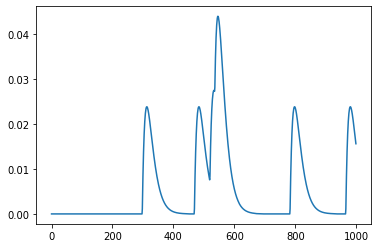

In [476]:
plt.plot(output.numpy().T[1000:2000])

In [394]:
Wce = np.array([[0,1,2,3,4],[5,6,7,8,9]])
tf.gather_nd(inputs, [[0],[1]])
indices = tf.constant([[0],[1]])
indices.shape

TensorShape([2, 1])

In [346]:
filt_length=100
dt=1
shape = tf.constant([len(Wce[0]), 1], tf.int32) 
filt_times = tf.tile(tf.reshape(tf.range(0, filt_length, dt, dtype=tf.float32), (1, filt_length)), shape)
# filt_times = tf.cast(filt_times, tf.float32)

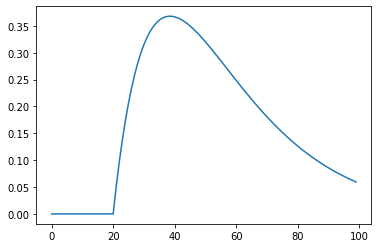

In [373]:
delay=20
filt = ((filt_times - delay) /  tf.reshape(Taue, (5,1))) * tf.math.exp(-(filt_times-delay)/tf.reshape(Taue, (5,1)))
filt = tf.clip_by_value(filt, clip_value_min=0, clip_value_max=10)
plt.plot(filt[4].numpy())